# Discrete Tomography


In [1]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import astra
import os

import utility as util
import astra_wrappers 
import cost_functions 
import reconstruction_alogrithms
import new_solution_generators
import postprocessing

## Loading images

In [2]:
phantom1 = ski.io.imread(os.path.join('data', 'phantom_sz64', 'ph1.png'))
phantom1 = util.fix_img(phantom1)
phantom2 = ski.io.imread(os.path.join('data', 'phantom_sz', 'ph2.png'))
phantom2 = util.fix_img(phantom2)
phantom3 = ski.io.imread(os.path.join('data', 'phantom_sz', 'ph3.png'))
phantom3 = util.fix_img(phantom3)

images = [phantom1, phantom2, phantom3]

titles = [
    f'Phantom 1 ({phantom1.shape[0]}x{phantom1.shape[1]})',
    f'Phantom 2 ({phantom2.shape[0]}x{phantom2.shape[1]})',
    f'Phantom 3 ({phantom3.shape[0]}x{phantom3.shape[1]})'
]

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# for i, ax in enumerate(axes):
#     ax.imshow(images[i], cmap='gray')
#     ax.set_title(titles[i])
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

(64, 64)


## Generating Test Data

Test data is generated using the **ASTRA Toolbox** via a preprocessing function:

```python
result = preprocess_image(image, show_results=False, angles=None, M=None)  # M being the number of sensors


result = {
    "phantom": img,
    "sinogram": sinogram,
    "rec_art": rec_art,
    "rec_fbp": rec_fbp,
    "system_matrix": W,
    "angles": angles
}
```

### Projection Setup

- **Number of projections** `p ∈ {2, 3, 5, 6}`
  - For `p ∈ {2, 3, 5}`: directions uniformly sampled from `[0°, 90°]`
  - For `p = 6`: directions sampled from `[0°, 150°]`
- **Measurements per direction**:
  - Phantom 1: `96`
  - Phantoms 2 & 3: `384`

### Noise Model

- Both **noiseless** and **noisy** data were used.
- Noise: additive Gaussian `𝒩(0, σ)`, with `σ ∈ {0.5, 1.5, 5}`
- Negative values were **clipped to zero**


In [3]:
p = [2, 5, 6]
angles = []
for p_val in p:
    angles.append(np.linspace(0, np.pi/2 + np.pi/3*(p_val == 6), num=p_val, endpoint=True))
rng = np.random.default_rng(42) # For reproducibility
M = [96, 384, 384]
std = [0, 1.5, 5]

# 1. Simulated Annealing with Hamming distance neighbours and Gauss regularization cost function

In [4]:
def SA1(image, res, plot=True):
    """
    Simulated Annealing reconstruction.
    """

    # --- Parameters---
    params = {
        "T_start": 4.0,
        "cooling_rate": 0.97,
        "max_iter": 20000,
        "epsilon": 0.00001,
        "verbose": False,

        "sigma": 0.5,  # Standard deviation for Gaussian regularization
        "r": 1,  # Regularization parameter for Gaussian regularization
        "gamma" : 14,
    }

    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_fbp"])

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_gauss_regularization,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel(), params["sigma"], params["r"], params["gamma"]),
        neighbour_function=neighbour_function,
        params=params
    )

    # SA.estimate_starting_temperature(100)
        
    best_img, best_cost, cost_history, temp_history = SA.run()
    print(f"Best cost: {best_cost}")
    
    if plot:
        plot_img = [image, best_img]
        plot_titles = ['phantom', 'result']
        util.plot_images(plot_img, plot_titles)

        fig, ax = plt.subplots(2, 1, figsize=(10,8))
        ax = ax.ravel()
        ax[0].plot(cost_history)
        ax[0].set_title('cost history')
        ax[1].plot(temp_history)
        ax[1].set_title('temperature history')
    return best_img


# 2. Simulated Annealing with edge changing neighbours with l2 + tv norm cost

In [5]:
def SA2(image, res, params=None, plot=True):
    """
    Simulated Annealing reconstruction.
    """
    if params is None:
        params = {
            "T_start": 0.1,
            "estimate_T0" : True,
            "cooling_rate": 0.99,
            "max_iter": 50000,
            "epsilon": 0.00001,
            "verbose": False,

            "lambda_tv": 0.001,

            "boundary_recalc_freq" : 100,
        }


    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_art"])
    # N = res["rec_fbp"].shape[0]
    # X0 = np.random.randint(0, 2, size=N*N)

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    neighbour_function = new_solution_generators.FlipOnEdge(
        res["rec_art"],
        params["boundary_recalc_freq"],
    )

    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_and_tv,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel(), params["lambda_tv"]),
        neighbour_function=neighbour_function,
        params=params
    )

    if params["estimate_T0"]:
        SA.estimate_starting_temperature(100)
        print(f"{SA.T=}")
        
    best_img, best_cost, cost_history, temp_history = SA.run()
    print(f"Best cost: {best_cost}")

    if plot:
        plot_img = [image, best_img]
        plot_titles = ['phantom', 'result']
        util.plot_images(plot_img, plot_titles)

        fig, ax = plt.subplots(2, 1, figsize=(10, 8))
        ax = ax.ravel()
        ax[0].plot(cost_history)
        ax[0].set_title('cost history')
        ax[1].plot(temp_history)
        ax[1].set_title('temperature history')
    return best_img

In [6]:
# --- Parameters---
params = {
    "T_start": 0.1,
    "estimate_T0": True,
    "cooling_rate": 0.99,
    "max_iter": 50000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
}

In [7]:
def SA3(image, res, params=None, plot=True):
    """
    Simulated Annealing reconstruction.
    """
    if params is None:
        params = {
            "T_start": 0.0,
            "estimate_T0": True,
            "cooling_rate": 0.99,
            "max_iter": 5000,
            "epsilon": 0.00001,
            "verbose": False,

            "lambda_tv": 0.001,

            "boundary_recalc_freq" : 100,
            "fixed_pixels_per_iter" : 10,
            "max_fix_iter" : 10,
        }

    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_art"])

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    neighbour_function = new_solution_generators.FlipOnEdge(
        res["rec_art"].ravel(),
        params["boundary_recalc_freq"],
        fix_high_distance_pixels=True,
        fixed_pixels_per_iter=params["fixed_pixels_per_iter"],
        max_fix_iter=params["max_fix_iter"]
    )

    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_and_tv,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel(), params["lambda_tv"]),
        neighbour_function=neighbour_function,
        params=params
    )

    if params["estimate_T0"]:
        SA.estimate_starting_temperature(100)
        print(f"{SA.T=}")
        
    best_img, best_cost, cost_history, temp_history = SA.run()
    print(f"Best cost: {best_cost}")
    
    if plot:
        plot_img = [image, best_img]
        plot_titles = ['phantom', 'result']
        util.plot_images(plot_img, plot_titles)

        fig, ax = plt.subplots(2, 1, figsize=(10, 8))
        ax = ax.ravel()
        ax[0].plot(cost_history)
        ax[0].set_title('cost history')
        ax[1].plot(temp_history)
        ax[1].set_title('temperature history')

    return best_img

In [20]:
# --- Parameters---
params = {
    "T_start": 0.0,
    "estimate_T0": True,
    "cooling_rate": 0.99,
    "max_iter": 5000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
    "fixed_pixels_per_iter" : 10,
    "max_fix_iter" : 10,
}

In [9]:
p = 6
sigma_percent = 0.1
M = 96

if p < 6:
    angles = np.linspace(0, np.pi/2, p)
else:
    angles = np.linspace(0, np.pi/2 + np.pi /3, p)


res = astra_wrappers.preprocess_image(phantom1, angles=angles, M=M, sigma_percent=sigma_percent)


Noise standard deviation is 0.1%, or 0.04800000041723251


Best cost: 408142.5549859848


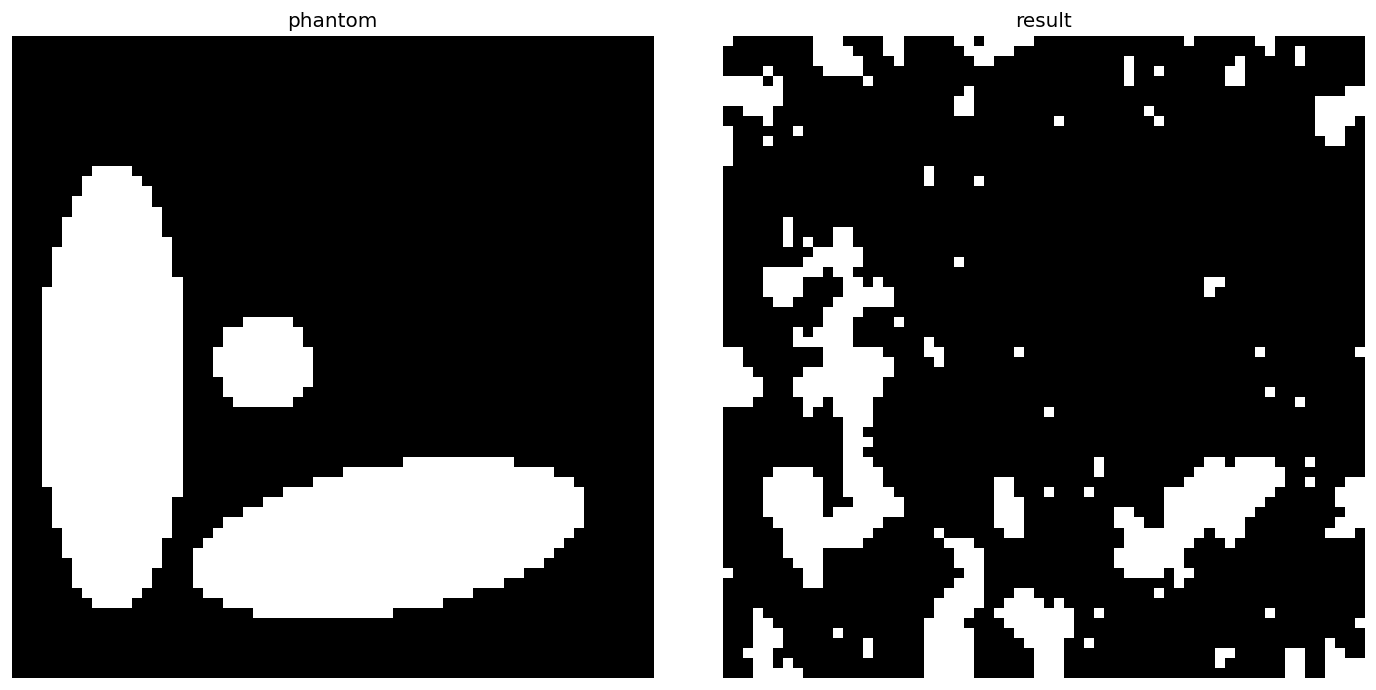

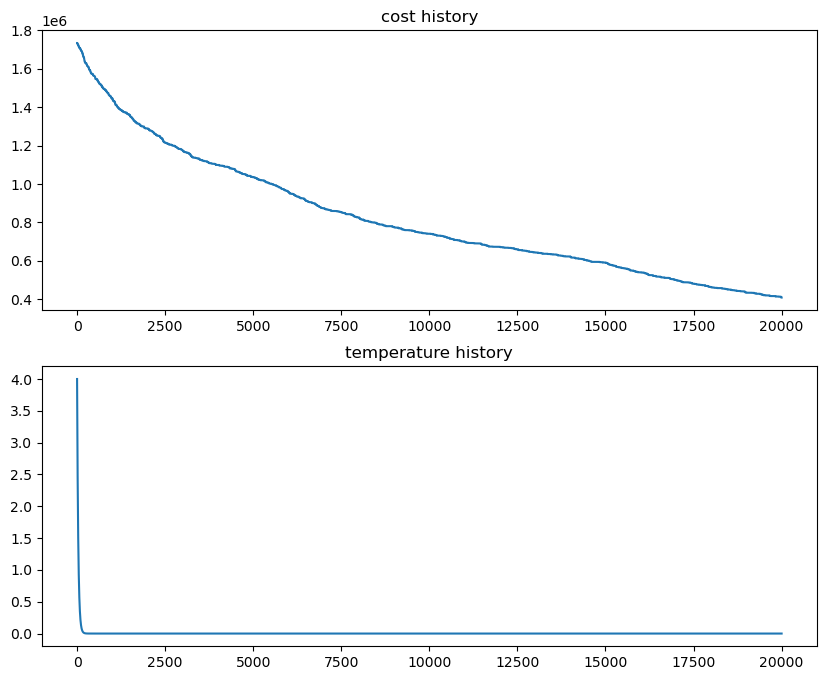

In [10]:
res_sa1 = SA1(phantom1, res)

SA.T=np.float64(387.0498295082649)
Best cost: 38.69353956154137


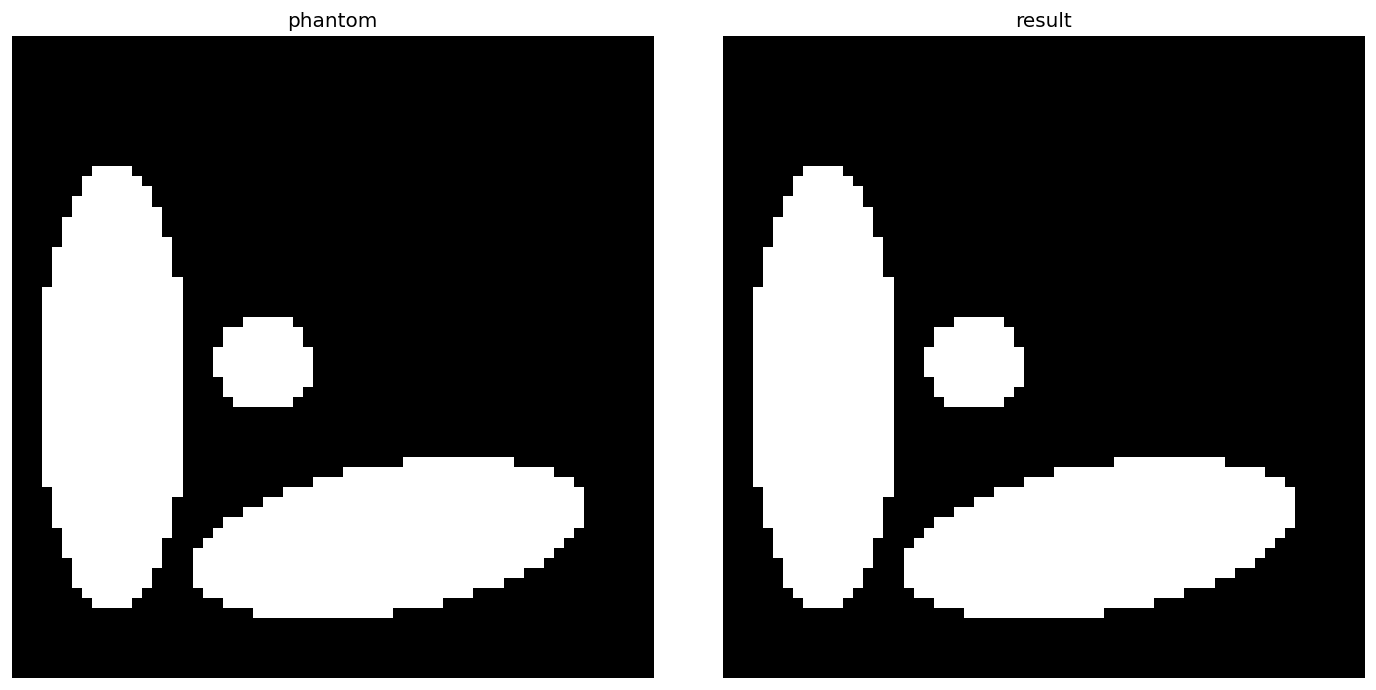

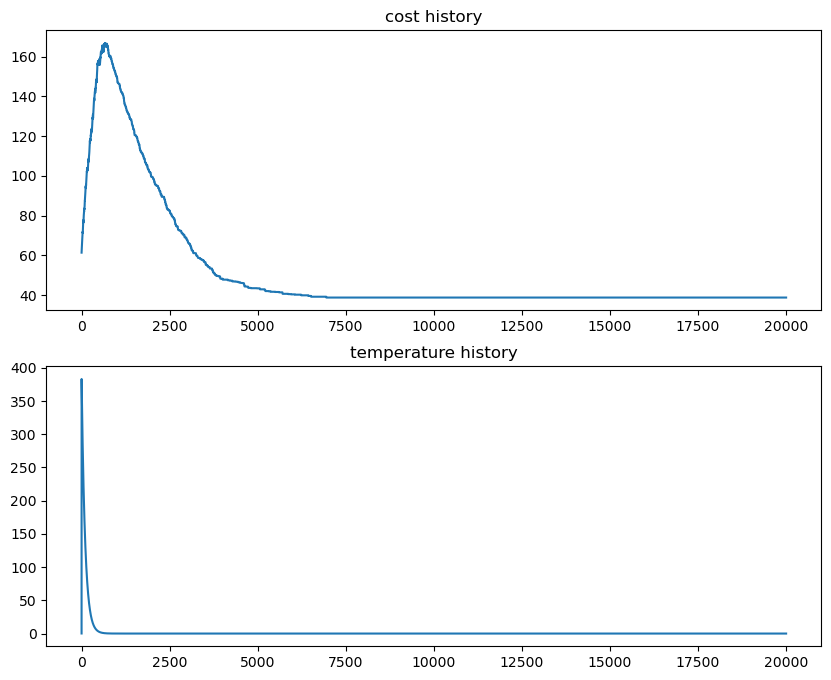

In [11]:
# --- Parameters---
params = {
    "T_start": 0.1,
    "estimate_T0": True,
    "cooling_rate": 0.99,
    "max_iter": 20000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
}

res_sa2 = SA2(phantom1, res, params, True)

SA.T=np.float64(387.0864328571929)
Best cost: 38.69353956154137


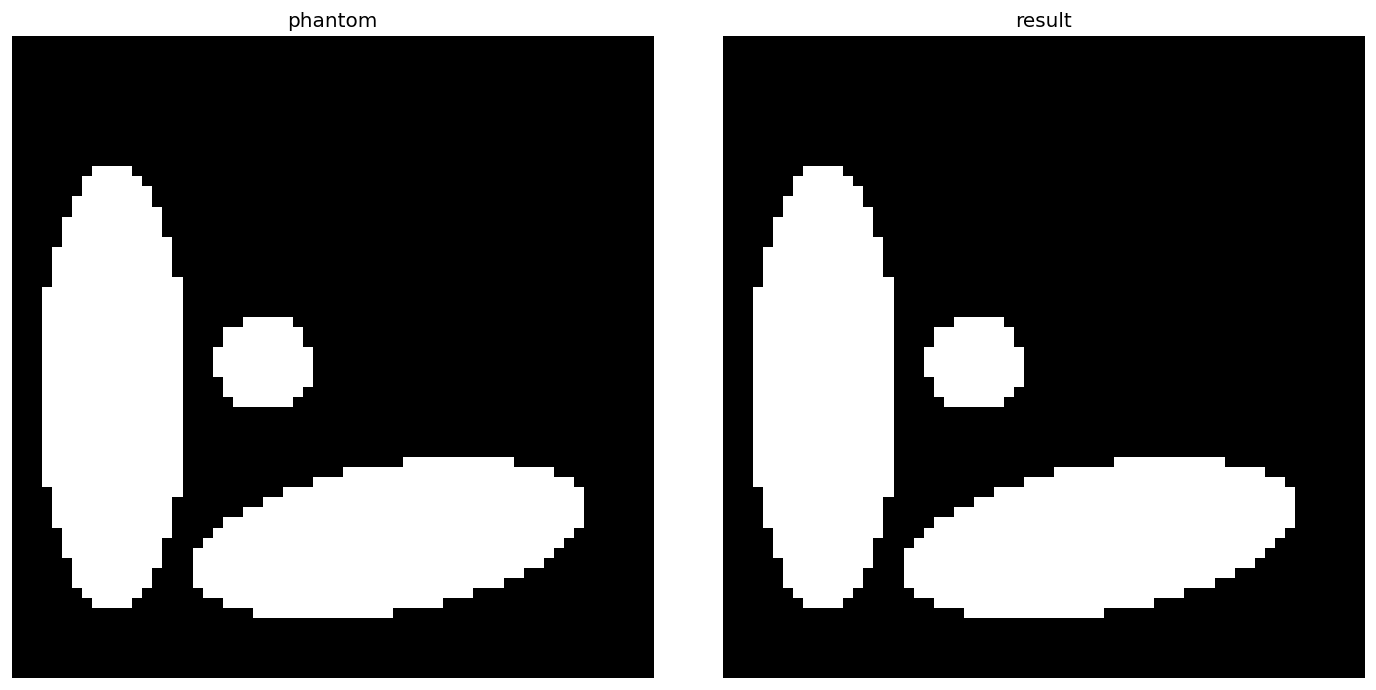

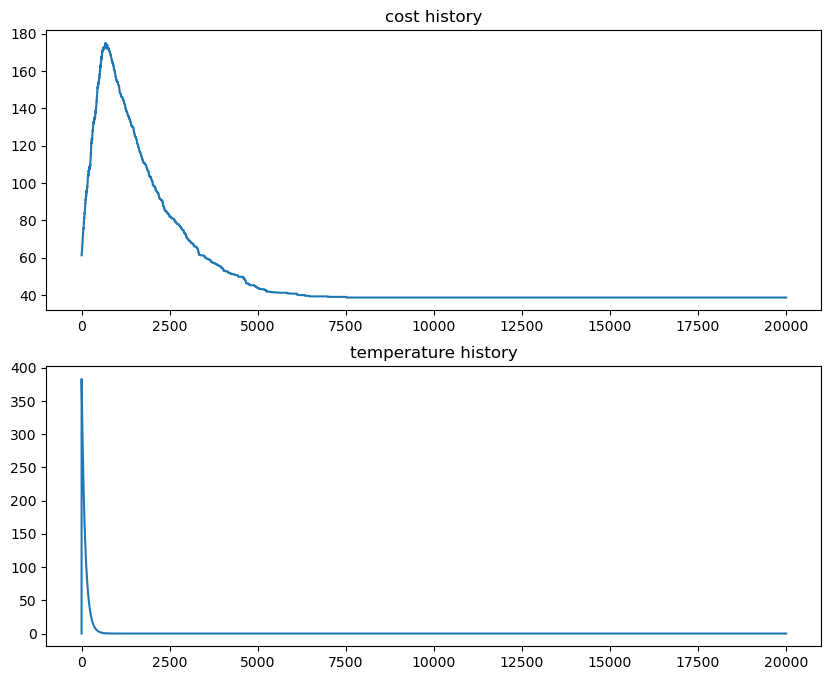

In [12]:
# --- Parameters---
params = {
    "T_start": 0.0,
    "estimate_T0": True,
    "cooling_rate": 0.99,
    "max_iter": 20000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
    "fixed_pixels_per_iter" : 50,
    "max_fix_iter" : 10,
}

res_sa3 = SA3(phantom1, res, params, True)

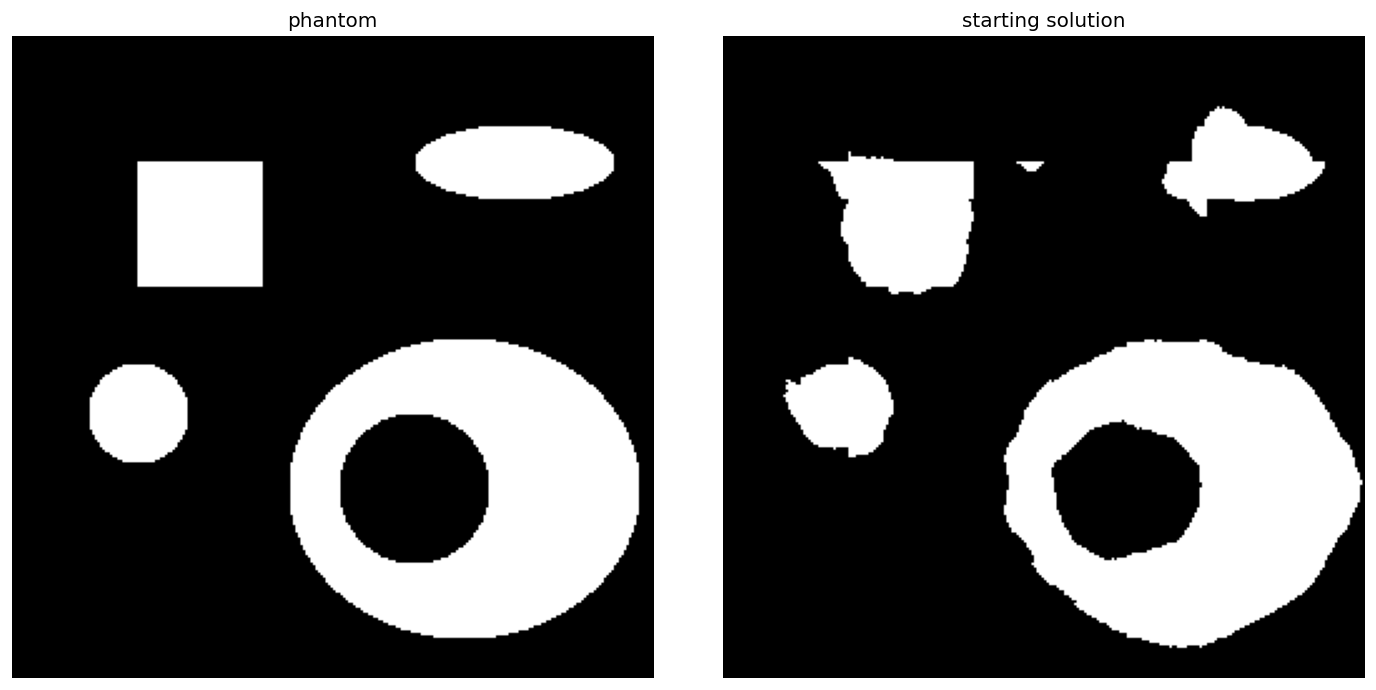

In [8]:
p = 6
sigma_percent = None
M = 348

if p < 6:
    angles = np.linspace(0, np.pi/2, p)
else:
    angles = np.linspace(0, np.pi/2 + np.pi /3, p)


res = astra_wrappers.preprocess_image(phantom2, angles=angles, M=M, sigma_percent=sigma_percent)
X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_fbp"])
N = int(np.sqrt(X0.shape[0]))
X0 = X0.reshape((N, N))
# sino = res['sinogram'].reshape(N, -1)
util.plot_images([phantom2, X0], ['phantom', 'starting solution'] )
plt.show()

Best cost: 22237843.286617763


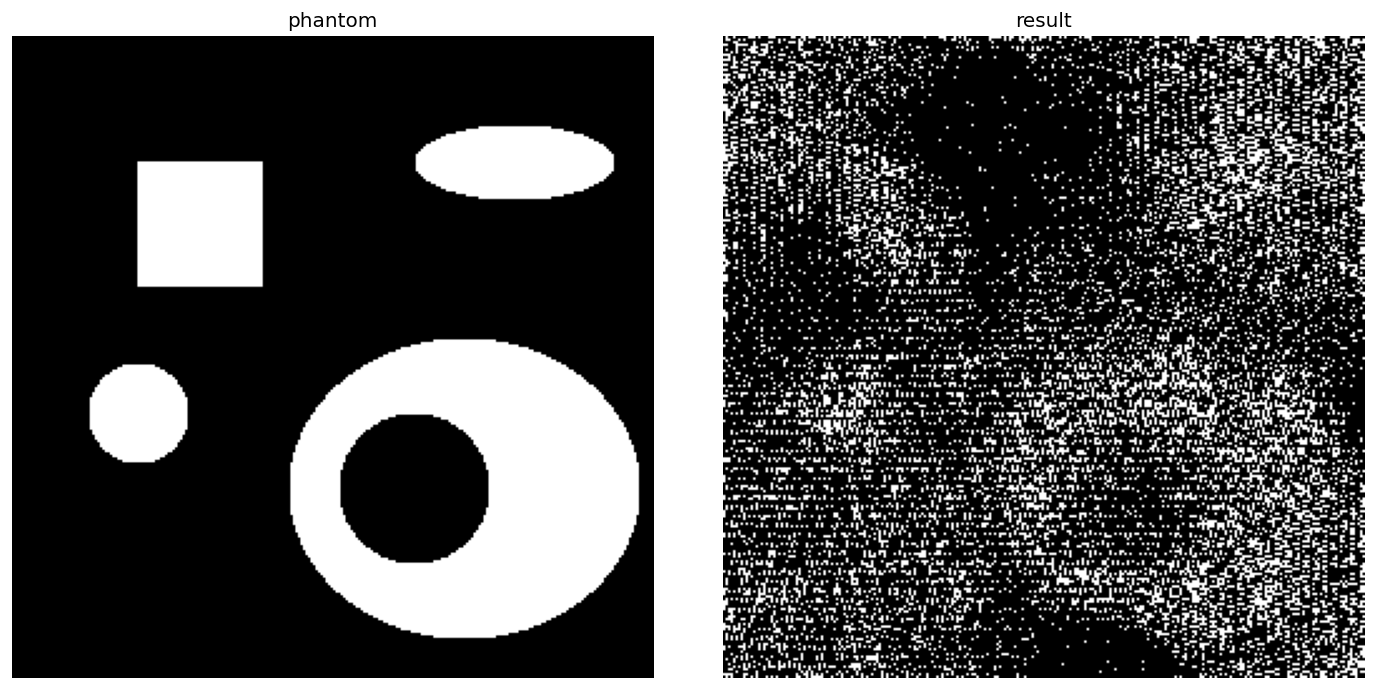

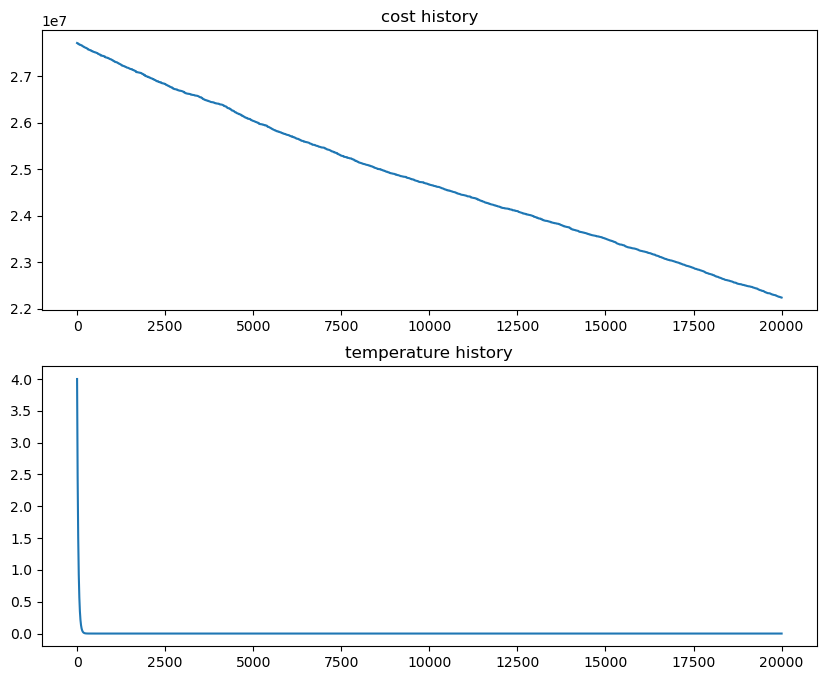

In [14]:
res_sa1_ph2 = SA1(phantom2, res)

SA.T=np.float64(3030.6706917358993)
Best cost: 496.0796122890895


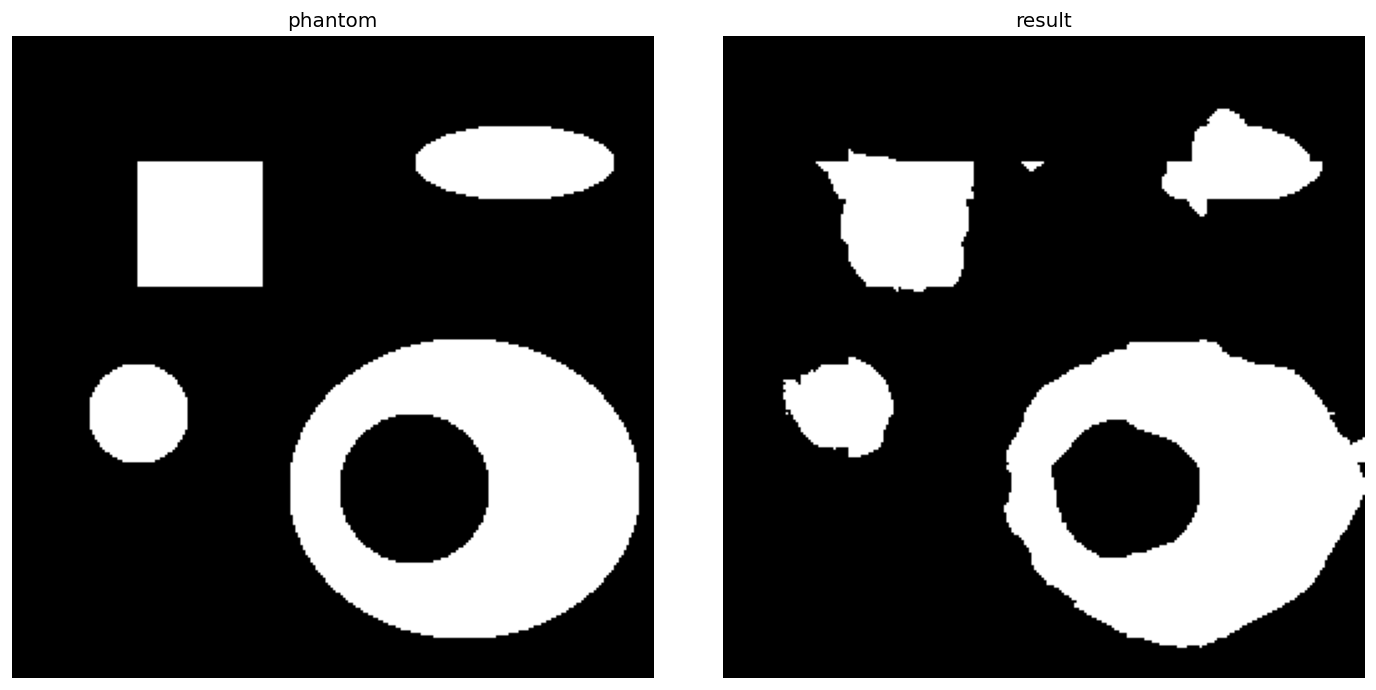

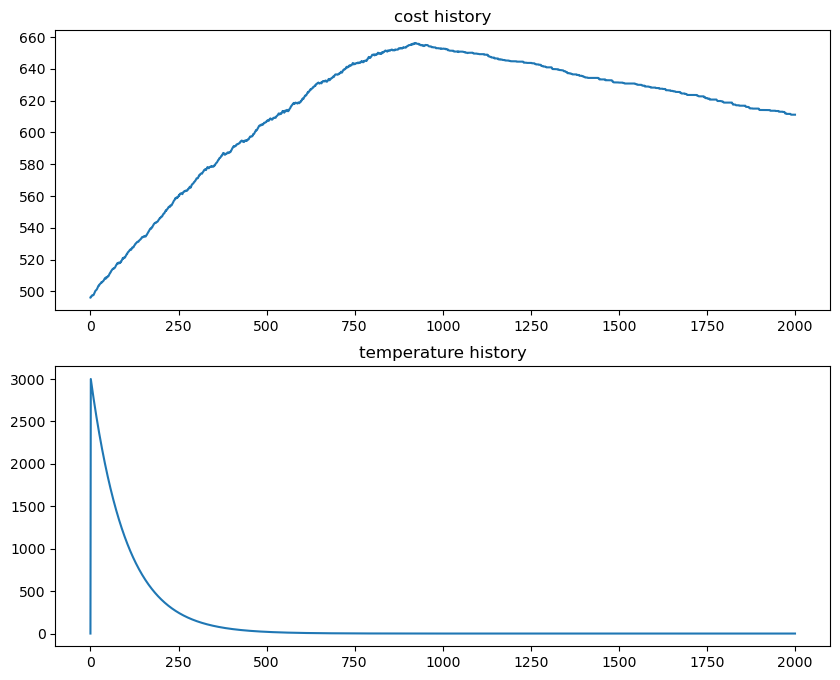

In [10]:
# --- Parameters---
params = {
    "T_start": 0.1,
    "estimate_T0": True,
    "cooling_rate": 0.99,
    "max_iter": 2000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
}

res_sa2_ph2 = SA2(phantom2, res, params, True)

SA.T=np.float64(3030.3519612023456)
Best cost: 496.0705478243959


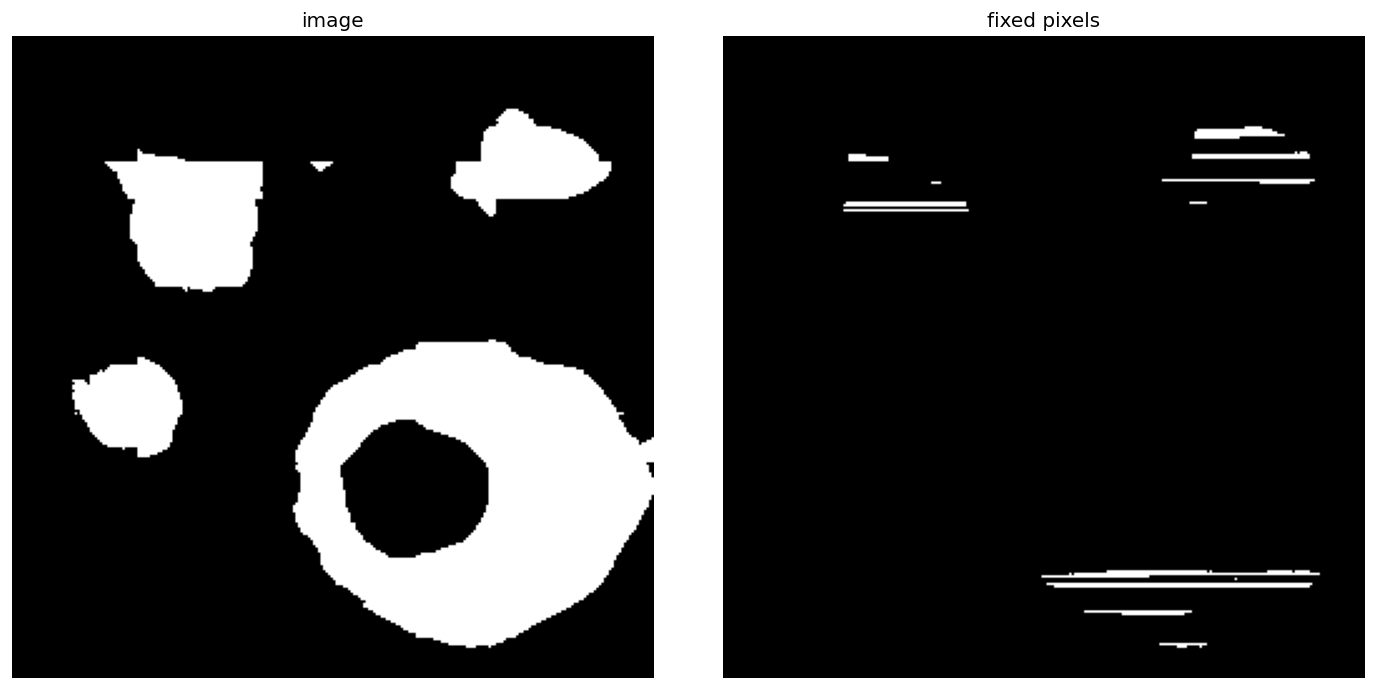

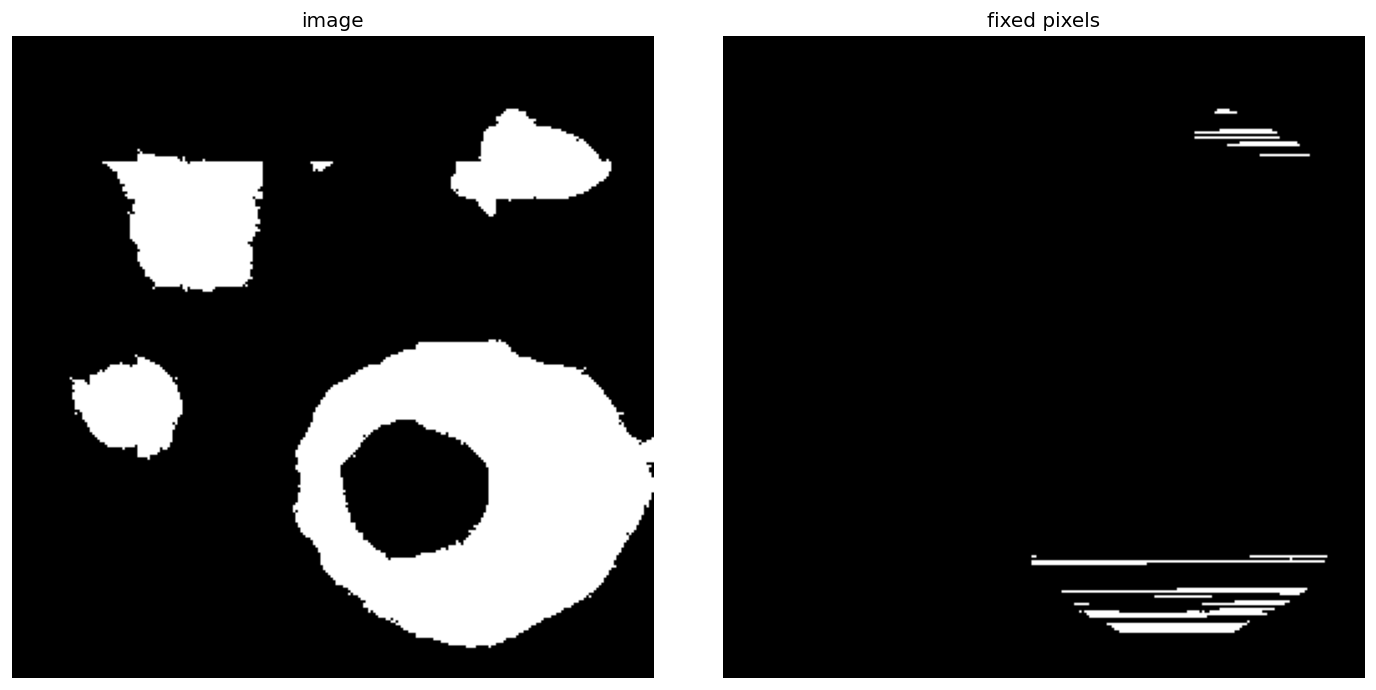

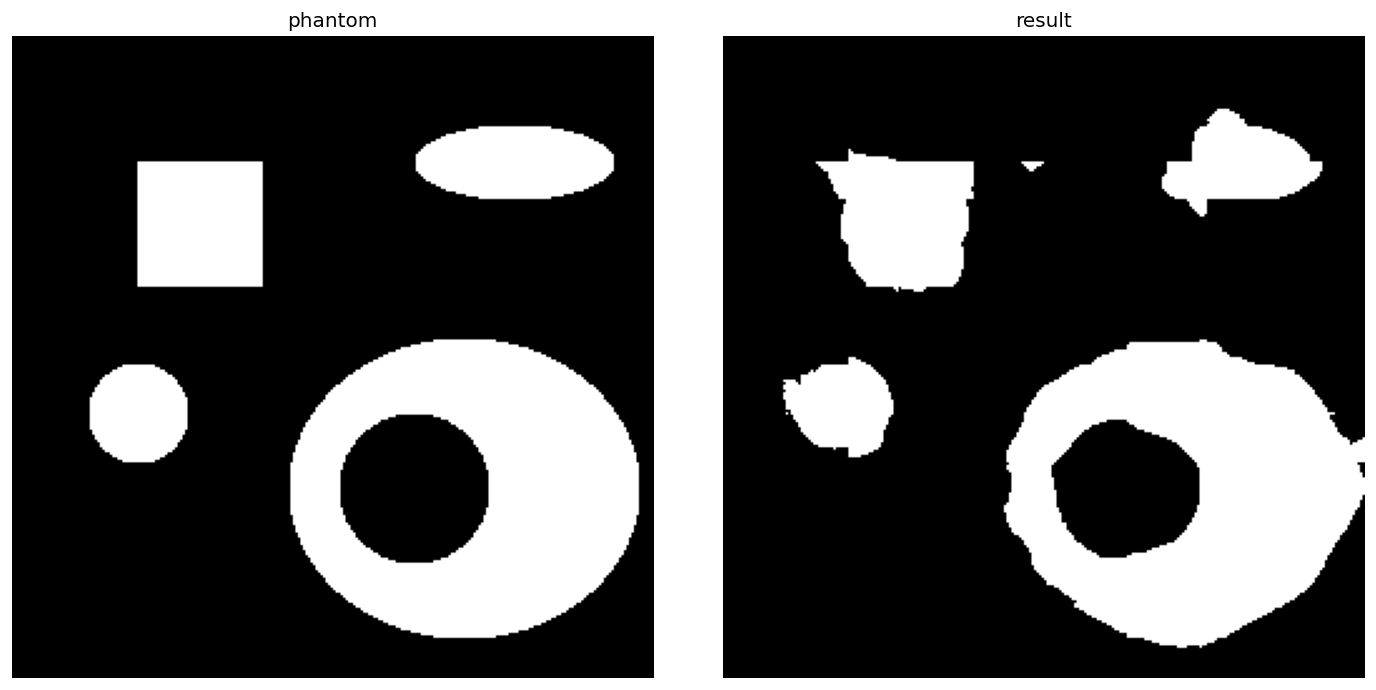

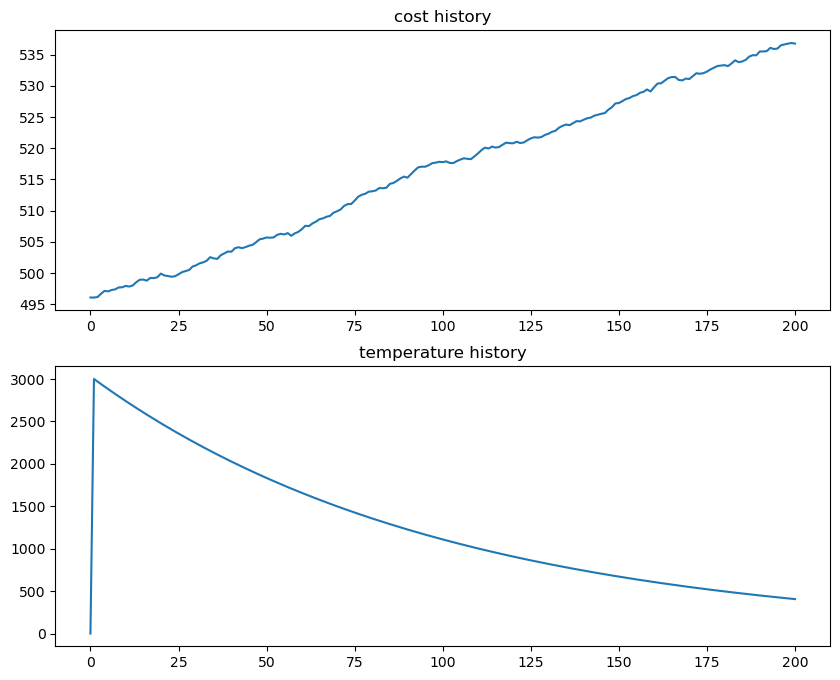

In [14]:
# --- Parameters---
params = {
    "T_start": 0.0,
    "estimate_T0": True,
    "cooling_rate": 0.99,
    "max_iter": 200,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
    "fixed_pixels_per_iter" : 1000,
    "max_fix_iter" : 10,
}

res_sa3_ph2 = SA3(phantom2, res, params, True)

In [17]:
p = 6
sigma_percent = 0.5
M = 348

if p < 6:
    angles = np.linspace(0, np.pi/2, p)
else:
    angles = np.linspace(0, np.pi/2 + np.pi /3, p)


res = astra_wrappers.preprocess_image(phantom3, angles=angles, M=M, sigma_percent=sigma_percent, show_results=False)

Noise standard deviation is 0.5%, or 0.6949999928474426


In [ ]:
res_sa1_ph3 = SA1(phantom3, res)

SA.T=np.float64(2388.818687802144)
Best cost: 605.1399375576159


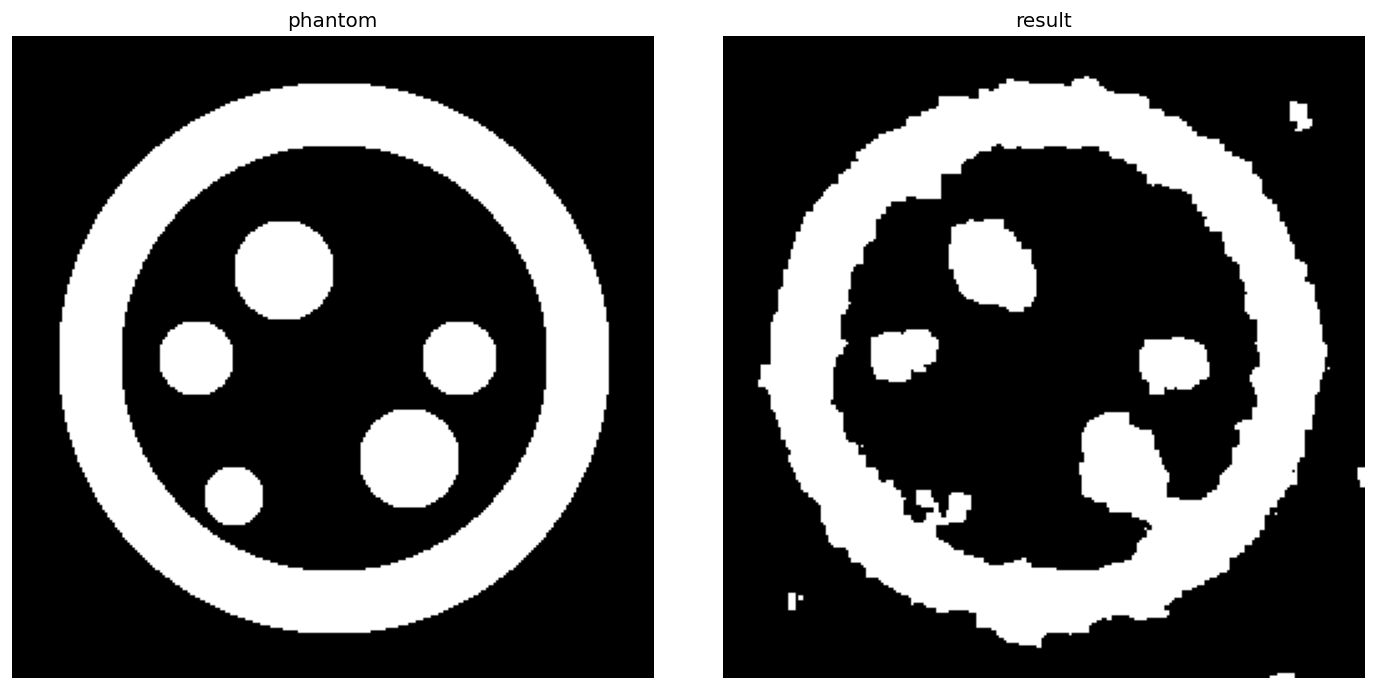

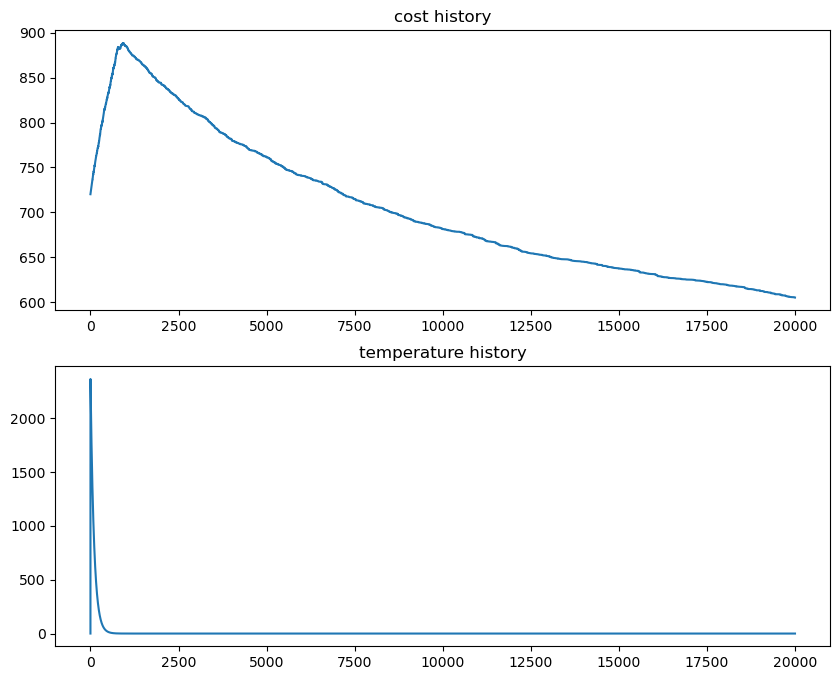

In [ ]:
# --- Parameters---
params = {
    "T_start": 0.1,
    "estimate_T0": True,
    "cooling_rate": 0.99,
    "max_iter": 20000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
}

res_sa2_ph3 = SA2(phantom3, res, params, True)

SA.T=np.float64(2390.212564154688)
Best cost: 613.7845748088955


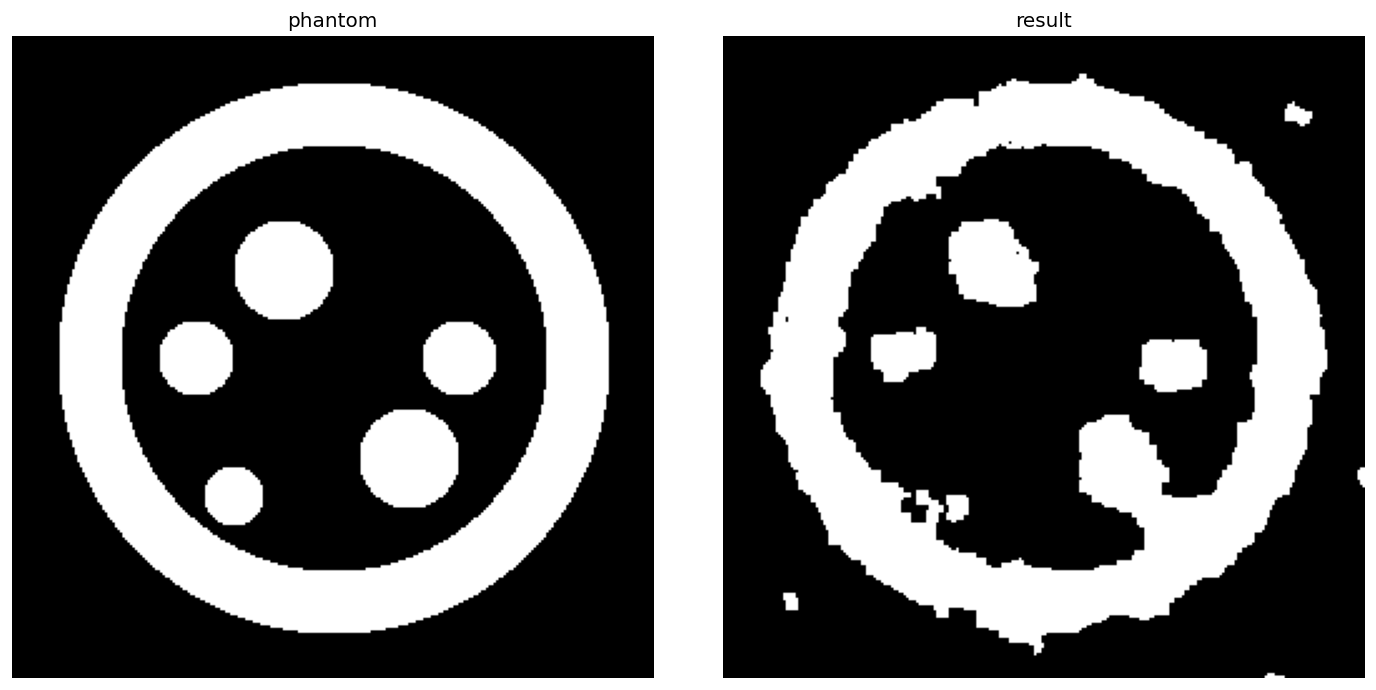

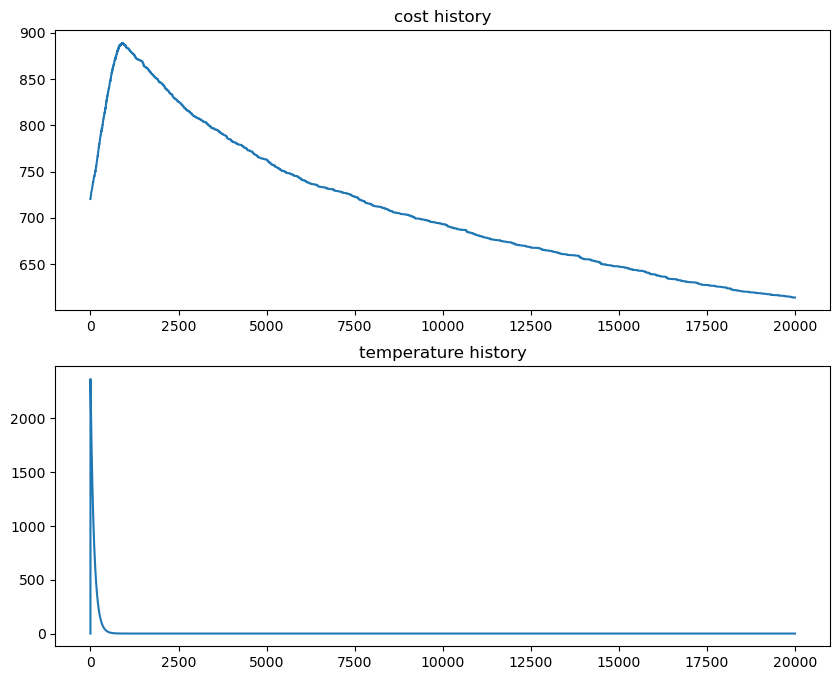

In [ ]:
# --- Parameters---
params = {
    "T_start": 0.0,
    "estimate_T0": True,
    "cooling_rate": 0.99,
    "max_iter": 20000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
    "fixed_pixels_per_iter" : 50,
    "max_fix_iter" : 10,
}

res_sa3_ph3 = SA3(phantom3, res, params, True)

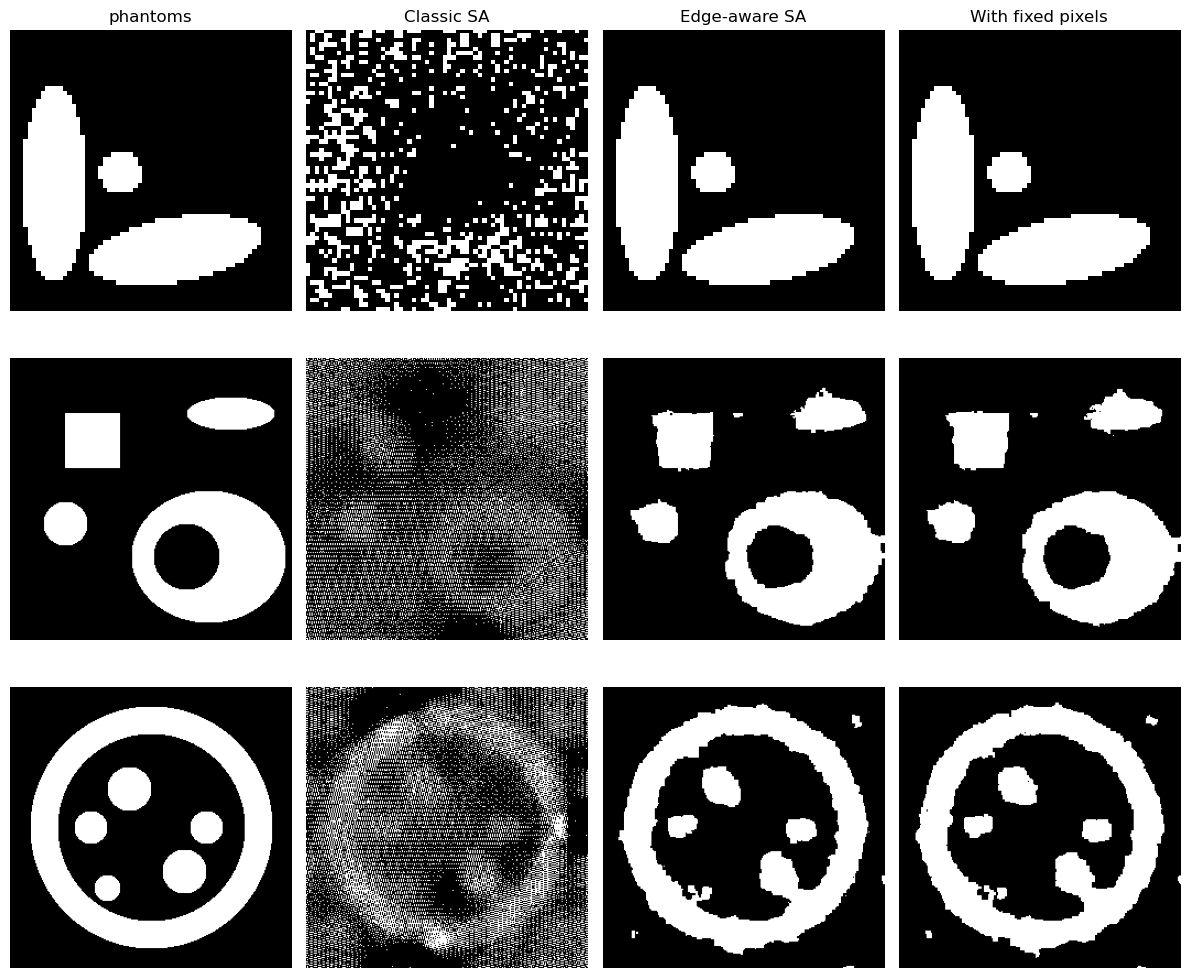

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(12, 10))
ax = ax.ravel()
for a in ax.ravel():
    a.axis('off')
fig.tight_layout()

ax[0].imshow(phantom1, cmap='gray')
ax[0].set_title('phantoms')

ax[1].imshow(res_sa1, cmap='gray')
ax[1].set_title('Classic SA')

ax[2].imshow(res_sa2, cmap='gray')
ax[2].set_title('Edge-aware SA')

ax[3].imshow(res_sa3, cmap='gray')
ax[3].set_title('With fixed pixels')

ax[4].imshow(phantom2, cmap='gray')
ax[5].imshow(res_sa1_ph2, cmap='gray')
ax[6].imshow(res_sa2_ph2, cmap='gray')
ax[7].imshow(res_sa3_ph2, cmap='gray')

ax[8].imshow(phantom3, cmap='gray')
ax[9].imshow(res_sa1_ph3, cmap='gray')
ax[10].imshow(res_sa2_ph3, cmap='gray')
ax[11].imshow(res_sa3_ph3, cmap='gray')


In [ ]:

N = image.shape[0]

# --- Prepare image and sinogram ------------------------------------------
# Geometry & projector
vol_geom, proj_geom, M, angles = astra_wrappers.make_geometries(N, angles, M=M)
proj_id = astra.create_projector(
    'strip',
    proj_geom, vol_geom
)

# --- Forward projection --------------------------------------------------
sinogram_id, sinogram = astra_wrappers.forward_project(image, vol_geom, proj_id)


# Add Gaussian noise
noisy_sino = sinogram + rng.normal(0, sigma, result['sinogram'].shape)
noisy_sino = np.clip(noisy_sino, 0, None)

noisy_sino_id = astra.data2d.create('-sino', proj_geom, sinogram=noisy_sino)

# --- Reconstructions ------------------------------------------------------
rec_art  = astra_wrappers.sart_reconstruction(noisy_sino_id, vol_geom, proj_id, n_iter=20)
rec_fbp, W  = astra_wrappers.lsqr_fbp_like(noisy_sino, proj_id, N)


# House-keeping
astra.data2d.delete(sinogram_id)
astra.data2d.delete(noisy_sino_id)
astra.projector.delete(proj_id)

# Return relevant data for further use
result = {
    "phantom": image,
    "sinogram": noisy_sino,
    "rec_art": rec_art,
    "rec_fbp": rec_fbp,
    "system_matrix": W,
    "angles" : angles
}

X0 = astra_wrappers.calculate_X0(noisy_sino, thetas, rec_art)

#  evaluate the 3 methods
for i, method in enumerate(['SA_basic_gaussian', 'SA_edge-aware_tv', 'SA_edge-aware_tv_fixed']):



    # dice = dice_score(image, rec_bin)
    # jaccard = jaccard_index(image, rec_bin)
    # e1 = normalized_l1(image, rec_bin)
    # e2 = normalized_l2(image, rec_bin)

    results.append({
        'method': method.upper(),
        'p': p,
        'angles_deg': angles_deg.round(2).tolist(),
        'DICE': dice,
        'Jaccard': jaccard,
        'E1 (L1)': e1,
        'E2 (L2)': e2
    })


NameError: name 'image' is not defined